**Goal: beat Andrej Karpathy's loss on the [makemore names dataset](https://github.com/karpathy/makemore/blob/master/names.txt).**

Context: in [*Building makemore Part 2: MLP*](https://www.youtube.com/watch?v=TCH_1BHY58I), Andrej Karpathy achieves a validation loss of 2.17 using a character-level MLP with one hidden layer, loosely modeled after [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). He then challenges the viewer to tune hyperparameters (but not the overall architecture) to beat his loss.

His hyperparameters/architecture:

- 3 letters of context.
- 10-dimensional embedding matrix.
- One hidden layer with 200 neurons.
- Activation function was tanh.
- 200,000 training loops – the first 100,000 with a learning rate of 0.1, and the next 100,000 with a learning rate of 0.01.
- Batch size of 32.
- Cross-entropy loss against one-hot encoded answers.

The architecture from Bengio:

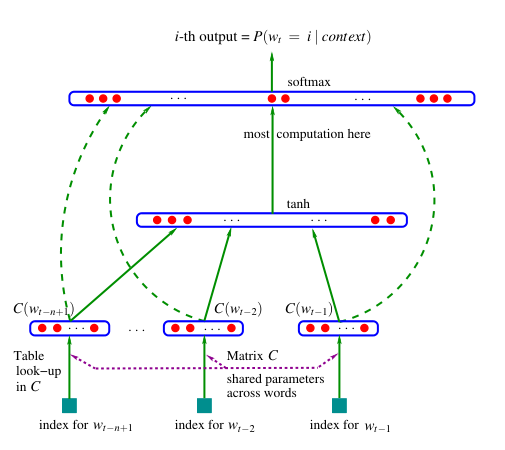

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [3]:
# Read names and create vocabulary
words = open("names.txt", "r").read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}

In [4]:
# Build dataset given a list of words
block_size = 4

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [5]:
# Shuffle and split into train (80%), dev (10%) and test (10%)
random.shuffle(words)

trainIdx = int(0.8*len(words))
devIdx = int(0.9*len(words))

Xtrain, Ytrain = build_dataset(words[:trainIdx])
Xdev, Ydev = build_dataset(words[trainIdx:devIdx])
Xtest, Ytest = build_dataset(words[devIdx:])

torch.Size([182485, 4]) torch.Size([182485])
torch.Size([22734, 4]) torch.Size([22734])
torch.Size([22927, 4]) torch.Size([22927])


In [6]:
# Initialize parameters
emb_dim = 32
hidden_layer_size = 250

C = torch.randn(len(chars) + 1, emb_dim) # embedding matrix
W1 = torch.randn(emb_dim * block_size, hidden_layer_size)
b1 = torch.randn(hidden_layer_size)
W2 = torch.randn(hidden_layer_size, len(chars) + 1)
b2 = torch.randn(len(chars) + 1)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [7]:
step_i = []
loss_i = []

In [8]:
batch_size = 32
training_loops = 300000

for i in range(training_loops):
    step_i.append(i)
    
    # Forward pass
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
    emb = C[Xtrain[ix]]
    h = torch.tanh(emb.view(-1, emb_dim * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    
    # Calculate loss
    # l2_lambda = 0.001
    # l2_norm = sum(p.pow(2.0).sum() for p in parameters)
    loss = F.cross_entropy(logits, Ytrain[ix]) #+ (l2_norm * l2_lambda)
    loss_i.append(loss.item())
    # print(loss.item())
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update parameters
    # learning_rate = learning_rates[len(learning_rates) * i // training_loops]
    learning_rate = 0.1 if i < (training_loops//3) else 0.03 if i < 2 * (training_loops//3) else 0.01
    for p in parameters:
        p.data -= learning_rate * p.grad

Dev loss (non-regularized): 2.1584033966064453
Train loss: 2.1848227977752686
Batch size: 32
Hidden layer neurons: 250
Embedding dimensions: 32
Block size: 4
Learning rate: 0.01
Training loops: 300000


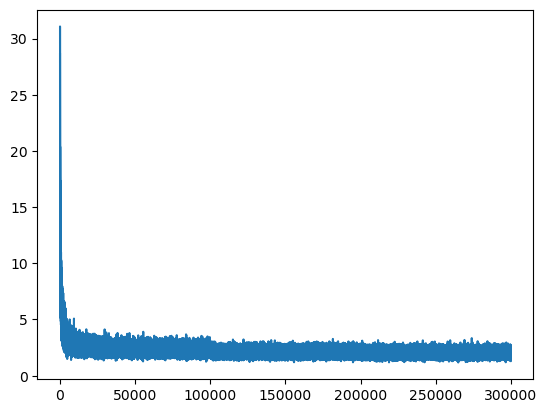

In [9]:
# Plot the loss curve
plt.plot(step_i, loss_i)

# Calculate the accuracy on the dev set
emb = C[Xdev]
h = torch.tanh(emb.view(-1, emb_dim * block_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
dev_loss = loss.item()
train_loss = loss_i[-1]
print(f"Dev loss (non-regularized): {loss.item()}")
# print(f"Dev loss (regularized): {(loss + (l2_norm * l2_lambda)).item()}")
print(f"Train loss: {loss_i[-1]}")
print(f"Batch size: {batch_size}\nHidden layer neurons: {hidden_layer_size}\nEmbedding dimensions: {emb_dim}\nBlock size: {block_size}\nLearning rate: {learning_rate}\nTraining loops: {training_loops}")

In [10]:
# Inference
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1, emb_dim * block_size) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out[:-1]]))

jolau
coctte
aris
niala
saze
lailah
diflane
talyn
macen
kubal


### Attempt 1

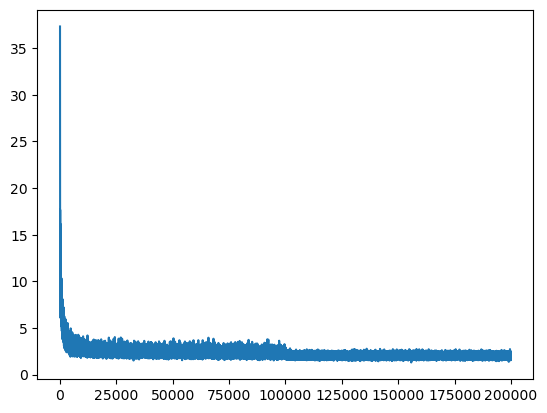

- Dev loss: 2.1757805347442627
- Train loss: 1.6896674633026123
- Batch size: 64
- Hidden layer neurons: 300
- Embedding dimensions: 32
- Block size: 5
- Learning rate: 0.1 for 100k, then 0.01 for 100k
- Training loops: 200,000

This worked decently well, but it seems to be overfitting to the data (note the big difference in training loss and dev loss). I think I'll increase the embedding dimensionality and batch size, and decrease the number of neurons in the hidden layer.

---

### Attempt 2

- Dev loss: 2.180579662322998
- Train loss: 1.8763939142227173
- Batch size: 128
- Hidden layer neurons: 200
- Embedding dimensions: 150
- Other hyperparameters unchanged.

This seems to have decreased the amount of overfitting, but doesn't seem to have improved the dev loss. I'll experiment with the learning rate and its decay next. In the Bengio paper, they used the following schedule:

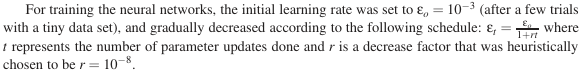

To find a good learning rate, I began by finding upper and lower limits via trial-and-error. It seems that learning converges most effectively between the bounds of 1e-3 and 1e0 (1).

I've created the following list of candidates:

```python
learning_rate_exps = torch.arange(-3, 0, 0.1)
learning_rates = torch.pow(10, learning_rate_exps)
```

And applied them over 10000 training iterations like so:

```python
learning_rate = learning_rates[len(learning_rates) * i // training_loops]
```

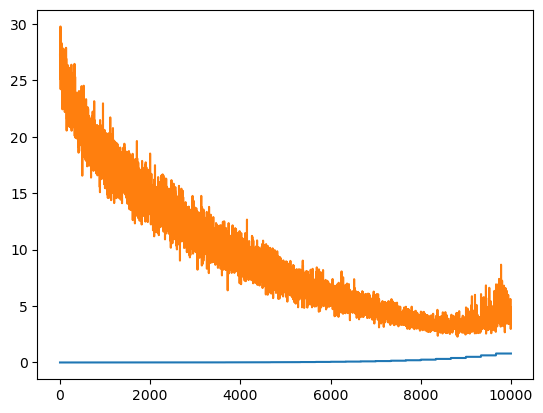

It looks like the loss gets a bit out of control when closer to 1, so I'll start with a learning rate of 0.1 and progressively decay over many iterations like so:

```python
learning_rate_exps = torch.arange(-1, -3, -0.01)
learning_rates = torch.pow(10, learning_rate_exps)
```

Which looks like this:

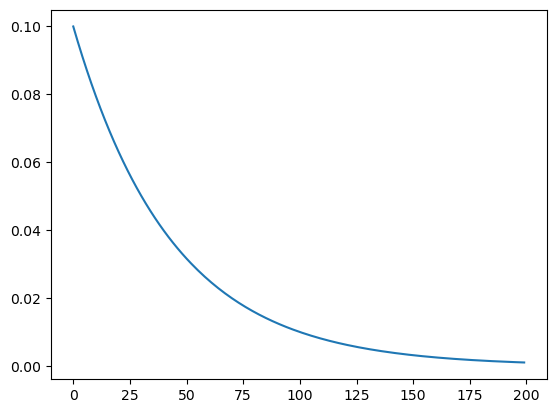

---

### Attempt 3

I kept the other hyperparameters the same. With the learning rate schedule above, I achieved:

- Dev loss: 2.258852481842041
- Train loss: 2.1663520336151123

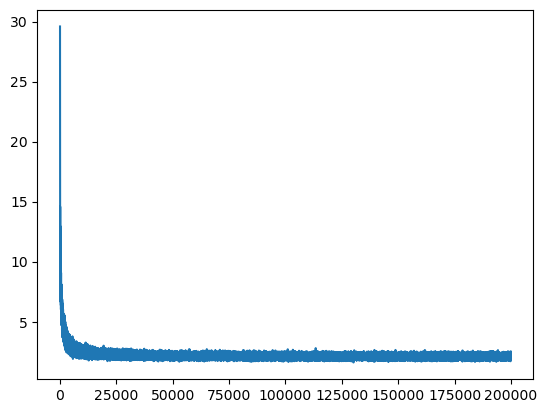

Disappointing! The names are feeling more realistic on inference, however: bartos, nimer, sospe, anoli, dalih, jenora. I'll try adding more neurons to see if a greater capacity helps.

---

### Attempt 4

The loss ended up *increasing*:

- Hidden layer neurons: 500
- Dev loss: 2.4537699222564697
- Train loss: 2.3439149856567383

I think I'll return to the hyperparameters from attempt 1, adding some L2 regularization to my loss to prevent overfitting. The learning rate schedule from attempt 1 falls within the bounds I found in attempt 2, so I'll go back to that as well.

```python
# Calculate loss with L2 regularization
l2_lambda = 0.001
l2_norm = sum(p.pow(2.0).sum() for p in parameters)
loss = F.cross_entropy(logits, Ytrain[ix]) + (l2_norm * l2_lambda)
```

---

### Attempt 5

Looks like the overfitting has been addressed. The non-regularized loss has gone up slightly, but the loss is *lower* on dev than on train. Promising!

- Dev loss (non-regularized): 2.2342617511749268
- Dev loss (regularized): 2.3739917278289795
- Train loss: 2.435587167739868
- Batch size: 64
- Hidden layer neurons: 300
- Embedding dimensions: 32
- Block size: 5
- Learning rate: 0.1 for 100,000 iterations, then 0.01 for 100,000 iterations
- Training loops: 200000

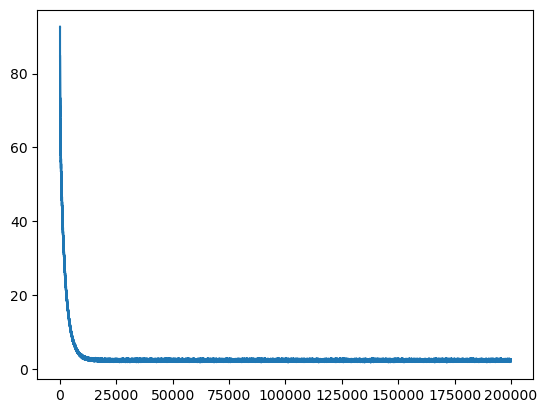

Note that the plotted loss includes the regularization component. Since overfitting has been reduced, let's try increasing the model's capacity and see if we can reduce loss.

---

### Attempts 6-9

I tried 64 embedding dimensions, which led to almost identical loss curves. 16 increased loss a bit, so I kept the 32 dimensions. I tried increasing the hidden layer to 400 neurons, but this slightly increased the loss as well. Then I tried increasing the hidden layer to 500 neurons and increasing the batch size to 128, which also slightly increased the loss.

---

### Attempt 10

Dev loss 2.25628924369812.

- 300,000 training loops.
- 0.1 learning rate for the first 100k, 0.03 for the next 100k, then 0.01 for the last 100k.
- Block size: 4
- Batch size: 32

---

### Attempt 11

Success! I kept the hyperparameters from 10, but removed the L2 regularization. This brought my loss down to ~2.158.

- Dev loss (non-regularized): 2.1584033966064453
- Train loss: 2.1848227977752686
- Batch size: 32
- Hidden layer neurons: 250
- Embedding dimensions: 32
- Block size: 4
- Training loops: 300000
- Learning rate: 0.1 for 100k, 0.03 for 100k, and 0.01 for the final 100k.

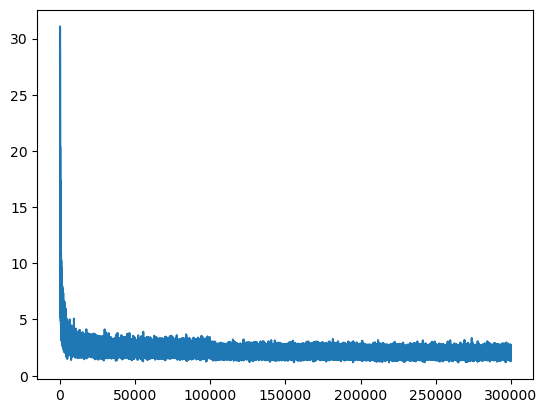

---

### Learnings

1. You can learn a great deal by reading papers and implementing them.
2. Sometimes simple approaches work well. Adding complexity is often the wrong approach.
3. Karpathy has good intuitions for this sort of thing.